In [1]:
!pip3 uninstall -y MultibandMRI 
!pip3 install git+https://github.com/AdaptiveMRILab/MultibandMRI.git

Found existing installation: MultibandMRI 0.1.0
Uninstalling MultibandMRI-0.1.0:
  Successfully uninstalled MultibandMRI-0.1.0
  Cloning https://github.com/AdaptiveMRILab/MultibandMRI.git to /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-6v00dlbo
  Running command git clone --filter=blob:none --quiet https://github.com/AdaptiveMRILab/MultibandMRI.git /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-6v00dlbo
  Resolved https://github.com/AdaptiveMRILab/MultibandMRI.git to commit 5d1aa365fd51f5f25eca2297d6c3c840cf7dfe76
  Preparing metadata (setup.py) ... done
  Created wheel for MultibandMRI: filename=MultibandMRI-0.1.0-py3-none-any.whl size=8254 sha256=70774654f0fcb1ca57aa23a766047051fc5ad1e315b9fdfee7faf9cca8a2a5b8
  Stored in directory: /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-ephem-wheel-cache-3ftt0iat/wheels/54/cc/03/f5b8e399de4023fd079a1dbf0b918dbad6f0787e62b15802b9
Successfully built MultibandMRI


In [2]:
import torch 
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
from MultibandMRI import slice_grappa, split_slice_grappa, sense_grappa, fft1d, fft2d, ifft1d, ifft2d

device = torch.device('cpu')

calibration_datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_12_03_CMT_2D/_Series_0000/recon.h5'
aliased_datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_19_18_CMT_2D/_Series_0000/recon.h5'


# Load the Calibration Data

In [3]:
num_calib_lines = 32

# these datasets were acquired with three contrasts 
# specify here which one to use 
contrast = 2

# fetch the k-space from the h5 file 
with h5py.File(calibration_datapath,'r') as F:
    ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]
ksp = torch.tensor(ksp, dtype=torch.complex64, device=device)

# extract each slice from the extended POMP FOV
img = ifft2d(ksp, dims=(0,1))
img = torch.stack([img[:,:128,:], img[:,128:256,:],img[:,256:,:]], axis=-1)
data = fft2d(img, dims=(0,1))

# add CAIPI shifts to calibration data 
data[:,1::3,:,0] = data[:,1::3,:,0] * np.exp(1j*2*np.pi/3)
data[:,2::3,:,0] = data[:,2::3,:,0] * np.exp(1j*4*np.pi/3)
data[:,1::3,:,2] = data[:,1::3,:,2] * np.exp(-1j*2*np.pi/3)
data[:,2::3,:,2] = data[:,2::3,:,2] * np.exp(-1j*4*np.pi/3)

# crop to the desired number of calibration lines
i1 = int(data.shape[1]/2 - num_calib_lines/2)
i2 = i1 + num_calib_lines 
calib_data = data[:,i1:i2,...]
calib_data = calib_data.permute(3,2,0,1)


# Calibrate the Kernels 

In [4]:
# only use 1 or 2 here
# using 3 would remove the CAIPI shifts!
in_plane_acceleration_factor = 1

readout_kernel_size = 5
phase_kernel_size = 4 if in_plane_acceleration_factor > 1 else 5
accel = (1, in_plane_acceleration_factor)
tik = 0.0

kernel_size = (readout_kernel_size, phase_kernel_size)
print(kernel_size)
sg = slice_grappa(calib_data, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=(128,128))

kernel_size = (readout_kernel_size, phase_kernel_size)
spsg = split_slice_grappa(calib_data, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=(128,128))

# kernel size along readout dimension should be even since there will be an effective acceleration due to SMS
kernel_size = (2*(readout_kernel_size//2), phase_kernel_size)
rosg = sense_grappa(calib_data, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=(128,128))


(5, 5)


# Load the Test Data

In [5]:
with h5py.File(aliased_datapath,'r') as F:
    aliased_ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]
aliased_ksp = torch.tensor(aliased_ksp, dtype=torch.complex64, device=device)
aliased_ksp = aliased_ksp.permute(2,0,1)[None,...]

# get the ACS data
num_acs_lines = 16
if num_acs_lines > 0:
    i1 = int(aliased_ksp.shape[-1]/2 - num_acs_lines/2)
    i2 = i1 + num_acs_lines 
    acs_data = aliased_ksp[...,i1:i2].clone()

# retrospective in-plane acceleration
for n in range(1,in_plane_acceleration_factor):
    aliased_ksp[...,n::in_plane_acceleration_factor] = 0.0

# put central ACS lines back into array
if num_acs_lines > 0:
    aliased_ksp[...,i1:i2] = acs_data 

# Do the Reconstructions

In [6]:
ksp_sg, rss_sg = sg.apply(aliased_ksp)
ksp_spsg, rss_spsg = spsg.apply(aliased_ksp)
ksp_rosg, rss_rosg = rosg.apply(aliased_ksp)

# Show the Results

Text(0.5, 1.0, 'SENSE-GRAPPA')

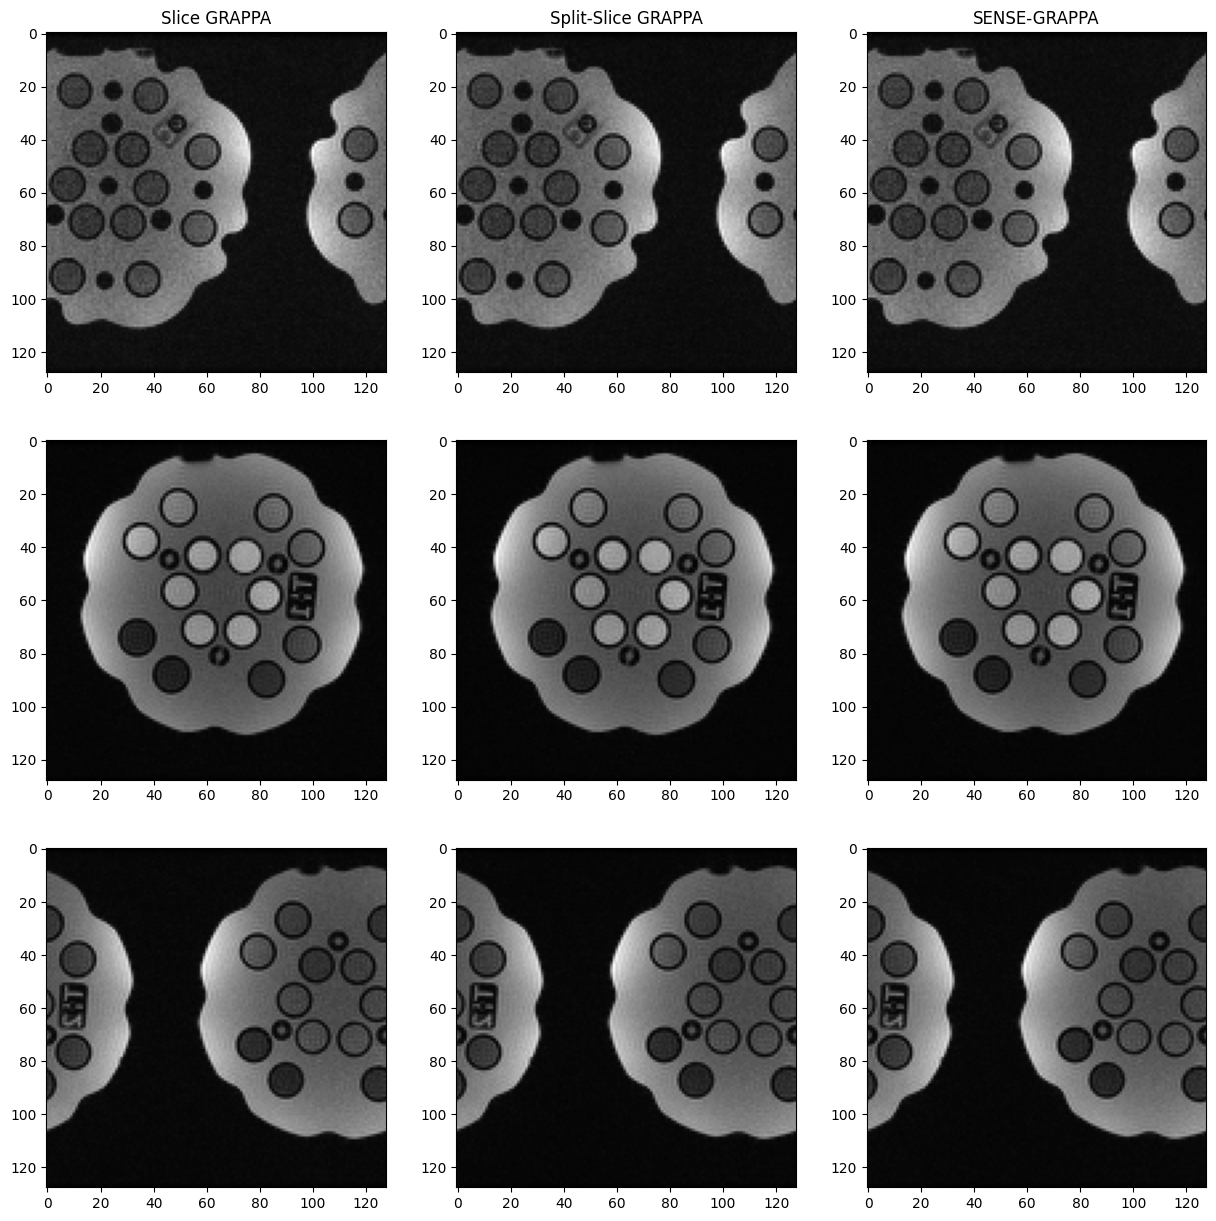

In [7]:
fig,ax = plt.subplots(3,3)
fig.set_figheight(15)
fig.set_figwidth(15)
for slc in range(3):
    ax[slc,0].imshow(rss_sg[slc,:,:], cmap='gray')
    ax[slc,1].imshow(rss_spsg[slc,:,:], cmap='gray')
    ax[slc,2].imshow(rss_rosg[slc,:,:], cmap='gray')
ax[0,0].set_title('Slice GRAPPA')
ax[0,1].set_title('Split-Slice GRAPPA')
ax[0,2].set_title('SENSE-GRAPPA')